In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from rcgp.rcgp import GPRegressor, RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

## Plot

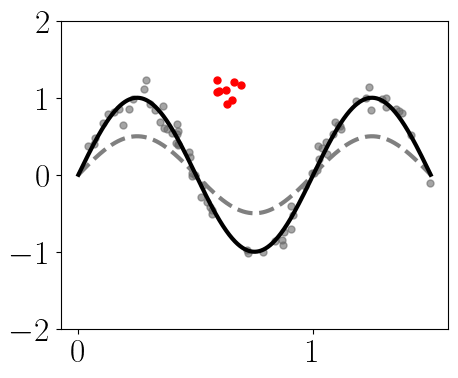

In [2]:
np.random.seed(41)

# Simulation
noise_var = 0.01
x_train = np.sort(np.random.uniform(0, 1.5, 80)).reshape(-1, 1)
mean_y = np.sin(2 * np.pi * x_train)
y_train = mean_y + np.random.normal(0, np.sqrt(noise_var), size=mean_y.shape)

# Add outliers
outlier_range = np.where((x_train >= 0.58) & (x_train <= 0.70))[0]
outlier_indices = np.sort(np.random.choice(outlier_range, 8, replace=False))
outlier_values = np.random.normal(loc=1.1, scale=0.2, size=outlier_indices.shape[0])
y_train[outlier_indices] = outlier_values.reshape(-1,1)

# Test points
x_test = np.linspace(0, 1.5, 1000).reshape(-1, 1)
mean_y_test = np.sin(2 * np.pi * x_test)

# Mask to keep all indices that are NOT outliers
mask = np.ones(len(x_train), dtype=bool)
mask[outlier_indices] = False
x_train_no_outliers = x_train[mask]
y_train_no_outliers = y_train[mask]

# Mean functions
sine_mean = SineMean(amplitude=0.5, frequency=2*np.pi)
constant_mean = ConstantMean(constant=0.0)


# Plot
plt.figure(figsize=(5, 4))
plt.plot(x_train[mask], y_train[mask], 'o', color='dimgray', markersize=5, alpha=0.6)  # darker grey, slightly transparent
plt.plot(x_train[~mask], y_train[~mask], 'o', color='red', markersize=5)               # red dots

plt.plot(x_test, sine_mean(x_test), '--', color='grey', linewidth=3)                     # thicker grey dashed prior mean
plt.plot(x_test, mean_y_test, color='black', linewidth=3)                              # thicker true function

plt.ylim(-2, 2)
plt.show()

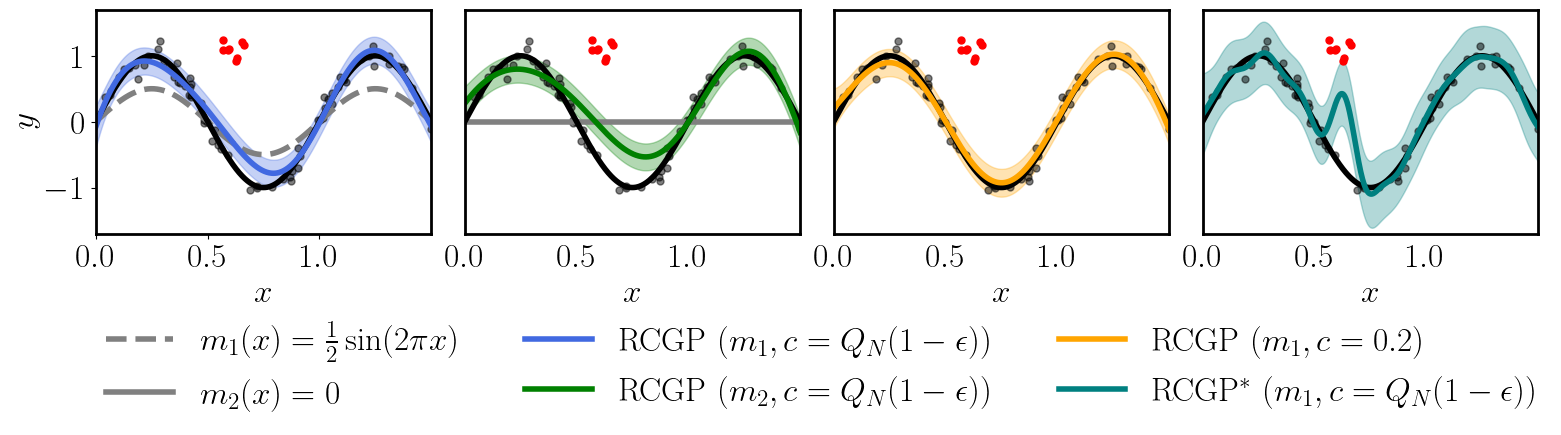

In [4]:
np.random.seed(41)

# Simulation
noise_var = 0.01
x_train = np.sort(np.random.uniform(0, 1.5, 80)).reshape(-1, 1)
mean_y = np.sin(2 * np.pi * x_train)
y_train = mean_y + np.random.normal(0, np.sqrt(noise_var), size=mean_y.shape)

# Add outliers
outlier_range = np.where((x_train >= 0.56) & (x_train <= 0.69))[0]
outlier_indices = np.sort(np.random.choice(outlier_range, 8, replace=False))
outlier_values = np.random.normal(loc=1.1, scale=0.2, size=outlier_indices.shape[0])
y_train[outlier_indices] = outlier_values.reshape(-1,1)

# Test points
x_test = np.linspace(0, 1.5, 1000).reshape(-1, 1)
mean_y_test = np.sin(2 * np.pi * x_test)

# Mask to keep all indices that are NOT outliers
mask = np.ones(len(x_train), dtype=bool)
mask[outlier_indices] = False
x_train_no_outliers = x_train[mask]
y_train_no_outliers = y_train[mask]

# Mean functions
sine_mean = SineMean(amplitude=0.5, frequency=2*np.pi)
constant_mean = ConstantMean(constant=0.0)

# Create a single row with 4 subplots
fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # adjust figsize as needed

initial_length_scale = 0.21
initial_rbf_variance = 1
initial_noise = 0.05

# ---------------- Plot 1: RCGP --------------------
epsilon = 0.1

rcgp = RCGPRegressor(mean = sine_mean, length_scale=initial_length_scale, rbf_variance = initial_rbf_variance, noise = initial_noise, epsilon = epsilon)
rcgp.fit(x_train_no_outliers, y_train_no_outliers)

rcgp.optimize_loo_cv()

rcgp.fit(x_train, y_train)
mu, var = rcgp.predict(x_test)
std = np.sqrt(var + noise_var)
sine_mean_test = sine_mean(x_test)

ax = axs[0]
axs[0].plot(x_train[mask], y_train[mask], 'o', color='black', alpha=0.5)
axs[0].plot(x_train[~mask], y_train[~mask], 'o', color='red')
axs[0].plot(x_test, sine_mean_test, '--', color='grey')
axs[0].plot(x_test, mean_y_test, color='black')
axs[0].plot(x_test, mu.ravel(), color="royalblue")
axs[0].fill_between(x_test.ravel(), mu.ravel() - 1.96 * std, mu.ravel() + 1.96 * std, alpha=0.3, color='royalblue')

# ---------------- Plot 2: Poor prior specification --------------------
epsilon = 0.1
rcgp = RCGPRegressor(mean = constant_mean, length_scale=initial_length_scale, rbf_variance = initial_rbf_variance, noise = initial_noise, epsilon = epsilon)
rcgp.fit(x_train_no_outliers, y_train_no_outliers)

rcgp.optimize_loo_cv()

rcgp.fit(x_train, y_train)
mu, var = rcgp.predict(x_test)
std = np.sqrt(var + noise_var)
constant_mean_test = constant_mean(x_test)

ax = axs[1]
axs[1].plot(x_train[mask], y_train[mask], 'o', color='black', alpha=0.5)
axs[1].plot(x_train[~mask], y_train[~mask], 'o', color='red')
axs[1].plot(x_test, constant_mean_test, '-', color='grey')
axs[1].plot(x_test, mean_y_test, color='black')
axs[1].plot(x_test, mu.ravel(), color="green")
axs[1].fill_between(x_test.ravel(), mu.ravel() - 1.96 * std, mu.ravel() + 1.96 * std, alpha=0.3, color='green')

# ---------------- Plot 3: Poor specification of c --------------------
epsilon = 0.8
rcgp = RCGPRegressor(mean = sine_mean, length_scale=initial_length_scale, rbf_variance = initial_rbf_variance, noise = initial_noise, epsilon = epsilon)
rcgp.fit(x_train_no_outliers, y_train_no_outliers)

rcgp.optimize_loo_cv()

rcgp.fit(x_train, y_train)
mu, var = rcgp.predict(x_test)
std = np.sqrt(var + noise_var)

ax = axs[2]
axs[2].plot(x_train[mask], y_train[mask], 'o', color='black', alpha=0.5)
axs[2].plot(x_train[~mask], y_train[~mask], 'o', color='red')
axs[2].plot(x_test, mean_y_test, color='black')
axs[2].plot(x_test, mu.ravel(), color="orange")
axs[2].fill_between(x_test.ravel(), mu.ravel() - 1.96 * std, mu.ravel() + 1.96 * std, alpha=0.3, color='orange')

# ---------------- Plot 4: Non-robust hyperparameter optimisation --------------------
epsilon = 0.1

rcgp = RCGPRegressor(mean = sine_mean, length_scale=initial_length_scale, rbf_variance = initial_rbf_variance, noise = initial_noise, epsilon = epsilon)
rcgp.fit(x_train, y_train)

rcgp.optimize_loo_cv(weighted=False)

mu, var = rcgp.predict(x_test)
std = np.sqrt(var + rcgp.noise)

ax = axs[3]
axs[3].plot(x_train[mask], y_train[mask], 'o', color='black', alpha=0.5)
axs[3].plot(x_train[~mask], y_train[~mask], 'o', color='red')
axs[3].plot(x_test, mean_y_test, color='black')
axs[3].plot(x_test, mu.ravel(), color="teal")
axs[3].fill_between(x_test.ravel(), mu.ravel() - 1.96 * std, mu.ravel() + 1.96 * std, alpha=0.3, color='teal')

# Set common limits and ticks
for ax in axs:
    ax.set_ylim(-1.7, 1.7)
    ax.set_xlim(0, 1.5)
    ax.set_xticks([0, 0.5, 1])
    ax.set_xlabel(r'$x$')

# Customize the y-axis of the first plot
axs[0].set_yticks([-1.0, 0, 1.0])
axs[0].set_ylabel(r'$y$')
for ax in axs[1:]:
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=True, labelleft=False)

handles = [
    axs[0].plot([], [], '--', color='grey', label=r'$m_1(x) = \frac{1}{2}\sin(2\pi x)$')[0],
    axs[0].plot([], [], '-', color='grey', label=r'$m_2(x) = 0$')[0],
    # axs[0].plot([], [], color='black', label='True function')[0],
    axs[0].plot([], [], color='royalblue', label=r'RCGP $(m_1, c= Q_{N}(1 - \epsilon))$')[0],
    axs[1].plot([], [], color='green', label=r'RCGP $(m_2, c= Q_{N}(1 - \epsilon))$')[0],
    axs[2].plot([], [], color='orange', label=r'RCGP $(m_1, c= 0.2)$')[0],
    axs[3].plot([], [], color='teal', label=r'RCGP$^\ast$ $(m_1, c= Q_{N}(1 - \epsilon))$')[0]
]

labels = [h.get_label() for h in handles]

# Add a figure-level legend below the subplots, larger font and no border
fig.legend(
    handles, 
    labels, 
    loc='lower center', 
    ncol=3, 
    bbox_to_anchor=(0.53, -0.17),  # Adjust vertical position
    prop={'size': 24},  # Large font
    frameon=False  # Remove legend border
)

for ax in axs:
    for spine in ax.spines.values():
        spine.set_linewidth(2)

plt.tight_layout()
plt.subplots_adjust(bottom=0.35, wspace = 0.1)  # Make more room for the bigger legend
plt.show()

# fig.savefig("./results/issues_rcgp.pdf", format='pdf', bbox_inches='tight')
